# Problem Set 2 (30 points)

Use the same `sentencing_cleaned` data from Problem Set 1 for this assignment. You can either read in the pkl or csv but if csv, follow the instructions in the Github issue here to recast some columns as datetime: https://github.com/rebeccajohnson88/qss20_slides_activities/issues/6#issuecomment-1013546655

In Problem Set 1, you investigated one form of disparity in the US criminal justice system: probation versus incarceration.

Here, you'll investigate a second type of disparity---the length of a defendant's sentence---and also investigate the disparities faced by defendants sentenced by the same judge for the same crime. 

As a reminder, the codebook is available at this link:  https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf)

# 0. Load packages and imports

In [72]:
## basic functionality
import pandas as pd
import numpy as np
import os
import plotnine
from plotnine import *
import matplotlib.pyplot as plt

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1.1 Read in the data and filter to defendants who were incarcerated and construct a sentence length variable (14 points)


### Part A

- Read in the data
- Filter to sentences that involve incarceration (same Illinois Department of Corrections logic as in problem set one: 
incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections")
- Using the `COMMITMENT_UNIT` column that represents sentence length, filter out the following non-numeric sentence lengths: Term, Pounds, Dollars, Ounces (year, months, natural life, days, hours, and weeks should remain)
- Filter to Black or White defendants

**Concepts tested and resources**: this question tests filtering rows based on logical conditions. Here are some resources:
- DataCamp on .loc: https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing-dataframes?ex=3
- Lecture 2 slide 19: https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing-dataframes?ex=3 
- Row subsetting section in this activity: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/activities/w22_activities/solutions/00_pandas_datacleaning_solutions.ipynb

**Hints on output**: we get 58289 rows remaining after this filtering. Don't worry about matching this exactly but try to get in the ballpark range. 

In [2]:
sentencing_cleaned = pd.read_pickle("sentencing_cleaned.pkl")

sentencing_cleaned = sentencing_cleaned[sentencing_cleaned.COMMITMENT_TYPE == "Illinois Department of Corrections"]

sentencing_cleaned = sentencing_cleaned[(sentencing_cleaned.COMMITMENT_UNIT != 'Term') & (sentencing_cleaned.COMMITMENT_UNIT != 'Pounds') & (sentencing_cleaned.COMMITMENT_UNIT != 'Dollars') & (sentencing_cleaned.COMMITMENT_UNIT != 'Ounces')]

sentencing_cleaned['is_black_or_white'] = (sentencing_cleaned.is_black_derived == True) | (sentencing_cleaned.is_white_derived == True)

sentencing_cleaned = sentencing_cleaned[sentencing_cleaned.is_black_or_white]




### Part B


Then, follow the instructions in the codebook (combining `COMMITMENT_TERM` with `COMMITMENT_UNIT`) to create a standard sentence length in days column (`senlength_derived`) that measures the sentence in **days**. To simplify, you can assume that:

- 1 hour = 1/24th of a day
- 1 year = 365 days
- 1 month = 30.5 days
- 1 week = 7 days
- Natural life = difference between the age of 100 and the defendant's age at incident (cleaned; if missing, code to age 20); note that this is a simplification since age at incident != age at sentencing 

Print the following cols for an example of each type (eg an example of originally hours; an example of natural life): `COMMITMENT_TERM`, `COMMITMENT_UNIT`, `age_derived` and your new standardized sentence length column (`senlength_derived`)

Print the summary of that column (`senlength_derived`) using the .describe() command

**Concepts tested and resources**: there are many approaches but a couple ways are:
- np.select covered in the slides and this activity notebook: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/activities/w22_activities/solutions/00_pandas_datacleaning_solutions.ipynb 
- writing a function that takes in one row as an argument and has a series of if, elif, else conditions where different commitment_units are translated into days. To execute this function, you can use the .apply function but apply it with axis = 1 (row-wise). Resources for that include: (1) the activity notebook on user-defined functions (https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/activities/w22_activities/solutions/02_loopsfunctions_solutions.ipynb); (2) the activity notebook covering apply: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/activities/w22_activities/solutions/00_pandas_datacleaning_solutions.ipynb

**Hint on output**: see GitHub issue for the summary stats we get from running .describe()

In [3]:
## Your code here on translation of units
# sentencing_cleaned['COMMITMENT_TERM']
sentencing_cleaned['senlength_derived'] = np.select([sentencing_cleaned['COMMITMENT_UNIT']=='Year(s)', 
                                                     sentencing_cleaned['COMMITMENT_UNIT']=='Months', 
                                                     sentencing_cleaned['COMMITMENT_UNIT']=='Weeks', 
                                                     sentencing_cleaned['COMMITMENT_UNIT']=='Hours', 
                                                     sentencing_cleaned['COMMITMENT_UNIT']=='Natural Life'],
                                                    [sentencing_cleaned['COMMITMENT_TERM'].astype(float) * 365,
                                                    sentencing_cleaned['COMMITMENT_TERM'].astype(float) * 30.5,
                                                    sentencing_cleaned['COMMITMENT_TERM'].astype(float) * 7,
                                                    sentencing_cleaned['COMMITMENT_TERM'].astype(float) / 24,
                                                    (100 - sentencing_cleaned['AGE_AT_INCIDENT'].astype(float)) * 365],
                                                    default=sentencing_cleaned['COMMITMENT_TERM'])

sentencing_cleaned = sentencing_cleaned.reset_index()

    

In [4]:
## Your code here on printing example of each type of committment unit and what it's senlength_derived is
sentencing_cleaned[['age_derived', 'COMMITMENT_UNIT', 'COMMITMENT_TERM', 'senlength_derived']].iloc[[1, 0, 58, 7656, 2541, 42044]]


,age_derived,COMMITMENT_UNIT,COMMITMENT_TERM,senlength_derived
1,30.0,Natural Life,1.0,25550.0
0,27.0,Year(s),62.0,22630.0
58,29.0,Months,18.0,549.0
7656,23.0,Weeks,2.0,14.0
2541,40.0,Days,90.0,90.0
42044,22.0,Hours,1.0,0.041667


In [5]:
## Your code here with the .describe() command summary of the senlength_derived column
sentencing_cleaned['senlength_derived'].describe()

count     58289.0
unique      240.0
top         365.0
freq      14456.0
Name: senlength_derived, dtype: float64

## 1.2 Examine disparities in length within the same judge and offense category: constructing matched pairs (16 points)



### Part A 

Keep the above ~58k row dataset that is subsetted to only to sentences involving incarceration. Then, further subset the rows to:
- Rows where `judgeid_derived` = `judge_21` 
- `simplified_offense_derived` == "Narcotics"

Use `shape` to print the dimensions of the resulting dataframe

**Concepts and resources**: row subsetting using logical conditions; see above resources

**Hint on output**: we get 53 rows after this filtering step. Don't worry about matching this exactly but try to get in the ballpark range. 

In [6]:
## your code here to filter rows and check the shape
sentencing_cleaned_21 = sentencing_cleaned[(sentencing_cleaned['judgeid_derived']=='judge_21') & (sentencing_cleaned['simplified_offense_derived']=='Narcotics')]
sentencing_cleaned_21.shape


(53, 55)

### Part B

For each defendant sentenced by judge_21, you want to construct a "matched group" of defendants who:

- Are the same exact age as the focal defendant (`age_derived`) and
- Are the same gender as the focal defendant (`is_male_derived`) but 
- Differ in race from the focal defendant (`is_black_derived`/`is_white_derived`)

Write a user-defined function to find any/all matched defendants for each focal defendant of judge 21. You can structure the function in various ways but one way is to write a function similar to the class example where we iterate over different DC crimes (focal crimes) and find similar crimes. For this problem, we want to:

- Iterate over unique defendants sentenced by judge 21 (use `CASE_PARTICIPANT_ID` to identify each unique defendant)
- Find other defendants in the judge 21 pool who (1) have a different race from that focal defendant but (2) the same gender and age 


**Concepts and resources**: 

- Slides and activity code on user-defined functions and iterating using list comprehension: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/activities/w22_activities/solutions/02_loopsfunctions_solutions.ipynb
- You can either write code in the function to add columns with the attributes of the focal defendant (existing material) or using `pd.merge` to join these on after; we'll be covering `pd.merge` Monday 01.24 but here are last year's slides (slide 17-20) in meantime: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/slides/s21_slides/qss20_s21_class4.pdf 


**Hints on output**: 

- Some focal defendants may not have any matches; they can be excluded from the results 
- In the way we wrote our function, each iteration of the function returns a single dataframe; because we execute via list comprehension, the output of this step is a list of dataframes (it's okay if you take a diff approach!)


In [7]:
## your code here to define function
def defendant_match(focal_defendant: pd.DataFrame):
    result = sentencing_cleaned_21[(sentencing_cleaned_21['age_derived']==focal_defendant['age_derived']) &
                               (sentencing_cleaned_21['is_male_derived']==focal_defendant['is_male_derived']) &
                               (sentencing_cleaned_21['is_black_derived']!=focal_defendant['is_black_derived'])]
    result['focal'] = focal_defendant['CASE_PARTICIPANT_ID']
    return result

# focus = sentencing_cleaned.iloc[4]
# focus[['CASE_PARTICIPANT_ID', 'age_derived', 'is_male_derived', 'is_black_derived']]
# defendant_match(focus)

In [24]:
## your code here to execute the function for all defendants sentenced by judge_21 
all_matches = []
for index in range(0, sentencing_cleaned_21.shape[0]):
    defendant = sentencing_cleaned_21.iloc[index]
    all_matches.append(defendant_match(defendant))
    

C:\Users\kaizh\AppData\Local\Temp/ipykernel_8384/3999043187.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Part C

Using the results from Part B, use `pd.concat` or another approach to create a dataframe that compares the (1) race and sentence length for the focal defendant to (2) the sentence length for other defendants. Using this dataframe, show this comparison for focal defendant: `CASE_PARTICIPANT_ID` == `808109112733`


In [23]:
## your code to rowbind all matches and to highlight the comparison
match_df = pd.concat(all_matches)
merged = match_df.merge(sentencing_cleaned_21, left_on='focal', right_on='CASE_PARTICIPANT_ID', suffixes=('_match', '_focal'))
merged = merged[['CASE_PARTICIPANT_ID_focal', 'CASE_PARTICIPANT_ID_match', 'is_black_derived_focal', 'senlength_derived_focal', 'senlength_derived_match']]
## for the example defendant 
example = merged.loc[merged['CASE_PARTICIPANT_ID_focal']==808109112733]
example

,CASE_PARTICIPANT_ID_focal,CASE_PARTICIPANT_ID_match,is_black_derived_focal,senlength_derived_focal,senlength_derived_match
56,808109112733,768307912970,True,2190.0,730.0
57,808109112733,769939231128,True,2190.0,730.0
58,808109112733,774967571640,True,2190.0,365.0


### Part D

Using the results from Part C, group by the focal defendant's race and find the proportion of that defendant's matches who had a LONGER sentence than the focal defendant

**Concepts and resources**: can use groupby and agg

- Groupby and agg code: https://github.com/rebeccajohnson88/qss20_slides_activities/blob/main/activities/w22_activities/solutions/00_pandas_datacleaning_solutions.ipynb

**Hints on output**: since we're grouping by race in the full pool, the resulting output should have two values: one for the rate at which Black defendants have matches with higher sentences; another for the rate at which White defendants have matches with higher sentences

In [25]:
## your code here 
merged['match_longer'] = merged['senlength_derived_match'] > merged['senlength_derived_focal']
merged.groupby('is_black_derived_focal')['match_longer'].agg('mean')

is_black_derived_focal
False    0.451613
True     0.483871
Name: match_longer, dtype: float64

### Part E 

Write 1-2 lines commenting on the results from Part D. What other defendant or offense-level characteristics would you like to match on to investigate claims about racial disparities? 


Based on the data, there is a higher proportion of white matches that have a longer sentence when compared to their black focal defendant than of black matches that have a longer sentence when compared to their white focal defendant. 
It might be interesting to look at the sentencing disparaties between white and black defendants by matching on different crimes such as violent crimes. It might also be interesting to match based on the date of incident to see how sentencing disparaties have changed over time.

# 2. Optional extra credit/challenge exercise (2 points): examine disparities across multiple judges

In problem 1.2, we focused on one judge: judge 21.
    
For this extra credit exercise, use the same data filtered to (1) incarceration, (2) Black/White only, and (3) narcotics offenses. 
    
- Get judges with a high enough sample of each group to compare sentencing: filter to each judge with at least 20 Black and at least 20 white defendants
- For each of the judges, calculate the median sentence length for their Black defendants and (2) the median sentence length for their white defendants 
- Create a barplot with the result: factor variable on x axis for each judge_id who qualifies; separate bars/colors by race
- Write a 1-2 sentence interpretation - if we assume that cases/defendants are randomly assigned to sentencing judges, what might this suggest about the role of judicial discretion in these disparities?


In [80]:
sentencing_cleaned_narc = sentencing_cleaned[sentencing_cleaned['simplified_offense_derived']=='Narcotics']
judges = sentencing_cleaned_narc.groupby('judgeid_derived')[['is_black_derived', 'is_white_derived']].agg('sum')

judges_good_sample = judges[(judges['is_black_derived']>=20) & (judges['is_white_derived']>=20)]
judges_good_sample = judges_good_sample.reset_index()
judges_list = judges_good_sample['judgeid_derived'].unique()
# judges_list
sentencing_cleaned_good_judges = sentencing_cleaned_narc.loc[sentencing_cleaned_narc['judgeid_derived'].isin(judges_list)]
medians = sentencing_cleaned_good_judges.groupby(['judgeid_derived', 'is_black_derived'])['senlength_derived'].agg('median')
median_df = medians.to_frame()
median_df
median_df = median_df.reset_index()

senlength_derived
judgeid_derived is_black_derived                   
judge_133       False                         365.0
                True                          488.0
judge_166       False                         365.0
                True                          365.0
judge_177       False                         365.0
                True                          730.0
judge_20        False                         365.0
                True                          730.0
judge_21        False                         730.0
                True                         1460.0
judge_279       False                         365.0
                True                          365.0
judge_320       False                        1095.0
                True                          730.0
judge_334       False                         365.0
                True                          730.0
judge_35        False                         671.0
                True                          549.0
judge_36        False                         457.5
                True                          730.0
judge_41        False                         365.0
                True                          365.0

<AxesSubplot:xlabel='judgeid_derived'>

Text(0.5, 1.0, 'Median Sentencing by Judge')

Text(0.5, 0, 'Judge ID')

Text(0, 0.5, 'Median Sentence Length (Days)')

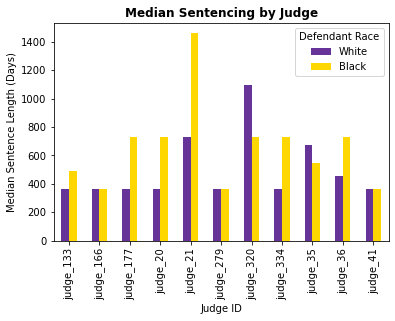

In [97]:
median_df_plot = median_df.pivot(index='judgeid_derived', columns='is_black_derived', values='senlength_derived')
median_df_plot.plot.bar(color=['rebeccapurple', 'gold'])
plt.title('Median Sentencing by Judge', fontweight='bold')
plt.xlabel('Judge ID')
plt.ylabel('Median Sentence Length (Days)')
plt.legend(['White', 'Black'], title='Defendant Race')
plt.show()


# 3. Optional extra credit/challenge exercise (2 points): impute possible demographic correlate of sentencing

The previous exercises showed large differences in sentences between judges/differences in disparities. You become interested in how the judge's own demographic attributes are correlated with sentencing. Going back to the judge's name (`SENTENCE JUDGE`), parse their first name and try to probabilistically infer his or her gender. Then, investigate whether disparities differ between "likely female" and "likely male" judges. 

**Note on ethics of probabilistic inference of attributes based on name**: Using names to infer demographic characteristics has become increasingly popular with the rise of "digital trace data" that often lacks explicit demographic fields (e.g., tweets just have usernames and profiles; academic citation networks just have author names). But there are many valid ethical critiques of this practice. In the case of gender, a person's assigned name at birth clearly does not always map onto their self-identified gender, both due to genders beyond the binary of male/female and names like "Morgan." A couple critiques I link to are:

- [This blog post](https://scatter.wordpress.com/2021/07/30/who-writes-social-science/)
- [Urban Institute ethical risks of race/ethnicity imputation - applies to gender](https://www.urban.org/research/publication/five-ethical-risks-consider-filling-missing-race-and-ethnicity-data)

 

In [12]:
# write code here
